#### 宽基指数

- 000016.SH # 上证50
- 000300.SH # 沪深300
- 000905.SH # 中证500
- 399006.SZ # 创业板指数（Top100）
- HSI # 恒生指数
- SPX # 标普500
- IXIC # 纳斯达克

#### 行业指数

- 000933.SH # 中证医药
- 000932.SH # 中证消费
- 000912.SH # 300消费 ;; 双均线收益大幅低于中证消费
- 000993.SH # 全指信息
- 000934.SH # 中证金融 ;; 中证金融地产指数由中证800指数样本股中的金融地产行业股票组成，以反映该行业公司股票的整体表现。
- 399986.SZ # 中证银行
- 000936.SH # 中证电信
- 000930.SH # 中证工业
- 000929.SH # 中证材料
- 000937.SH # 中证公用
- 000928.SH # 中证能源
- 399971.SH # 中证传媒
- 000852.SH # 中证1000
- 000827.SH # 中证环保
- 399967.SZ # 中证军工

#### 主题指数

- 000922.SH # 中证红利
- 399997.SZ # 中证白酒
- 399812.SZ # 养老产业

In [197]:
import talib as ta
import numpy as np
import tushare as ts
import matplotlib.pyplot as plt
import pandas as pd
import os

In [198]:
from matplotlib import font_manager

fontP = font_manager.FontProperties()
fontP.set_family('SimHei')
fontP.set_size(14)

In [199]:
pro = ts.pro_api(os.environ['TUSHARE_API_TOKEN'])

In [307]:
start = '20040101'                 # 回测起始时间
end = '20200801'                   # 回测结束时间
code = '399812.SZ'                 # 回测标的代码

short_term = 11
long_term = 22

In [308]:
data = pro.index_daily(ts_code=code, start_date=start, end_date=end).sort_index(ascending=False)
#data = pro.index_global(ts_code='HSI', start_date=start, end_date=end).sort_index(ascending=False) # 恒生
#data = pro.index_global(ts_code='SPX', start_date=start, end_date=end).sort_index(ascending=False) # 标普500
#data = pro.index_global(ts_code='IXIC', start_date=start, end_date=end).sort_index(ascending=False) # 纳斯达克

In [309]:
close_price = np.array(data['close'])
open_price = np.array(data['open'])
time = np.array(data['trade_date'])
L=[time[i] for i in range(0,len(time),60)]

# 计算均线数值
short_ma = ta.MA(close_price, short_term)
long_ma = ta.MA(close_price, long_term)

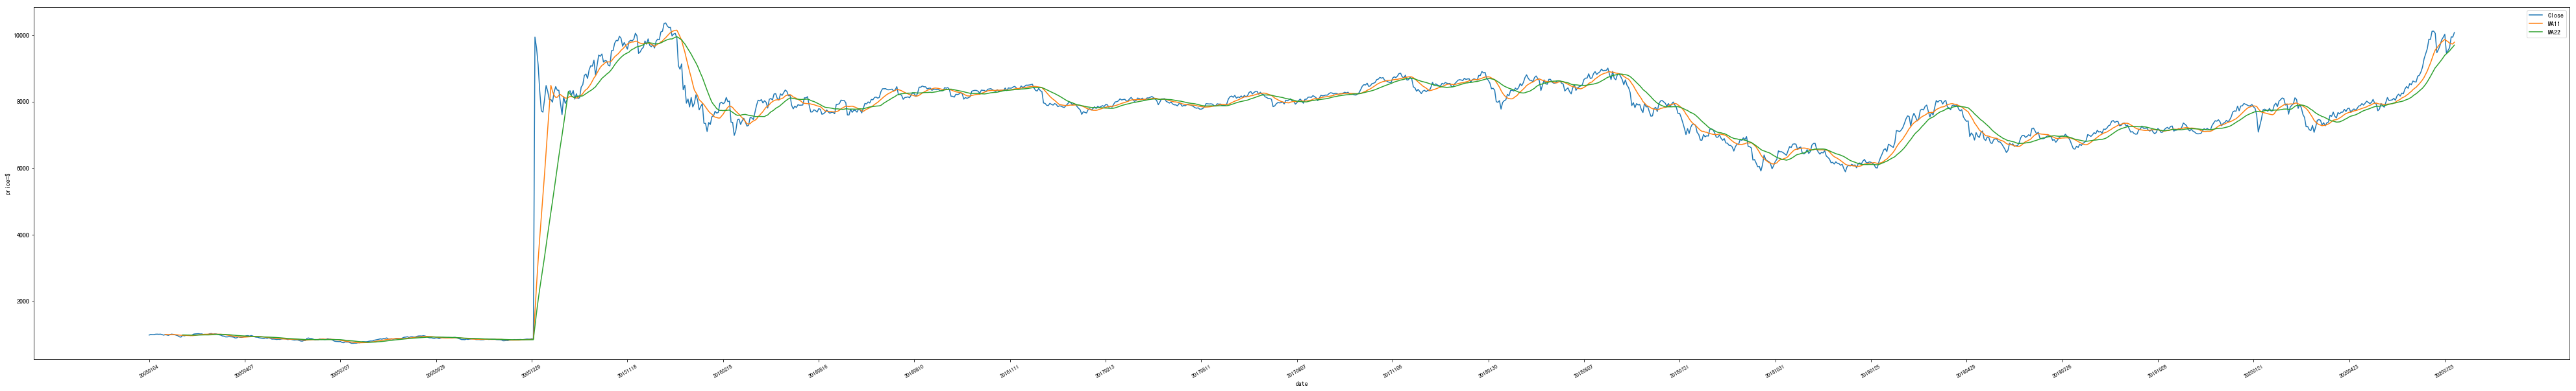

In [310]:
fig,ax=plt.subplots(figsize=(70,10))
ax.plot(time, close_price, label='Close')
ax.plot(time, short_ma, label='MA11')
ax.plot(time, long_ma, label='MA22')
ax.legend(loc='best')
ax.set_xticks(L)
ax.set_xlabel('date')
ax.set_ylabel('price=$')
plt.xticks(rotation=30,fontsize='small')
plt.show()

In [311]:
s = np.zeros(len(close_price))

is_hold = 0 # 0 - 空仓，1 - 买入，2 - 持仓，3 - 卖出

init_money = position_money = 1000000
position_amount = 0

trade_count = 0

buy_position_value = 0 # 每笔交易买入前总资金

for i in range(len(close_price)):
    trade_price = round((close_price[i] + open_price[i]) / 2, 2)
    if i == 0:
        s[0] = init_money
        continue
    if short_ma[i - 1] > long_ma[i - 1]: # 延迟一天，禁止使用未来函数
        if is_hold == 0: # 空仓买入
            is_hold = 1
            buy_position_value = position_money
            position_amount = int(position_money / trade_price)
            position_money = position_money - position_amount * trade_price
        elif is_hold == 1: # 买入持有
            is_hold = 2
        elif is_hold == 2: # 继续持有
            is_hold = 2
        elif is_hold == 3: # 卖出再次买入
            is_hold = 1
            buy_position_value = position_money
            position_amount = int(position_money / trade_price)
            position_money = position_money - position_amount * trade_price
    else:
        if is_hold == 0: # 空仓继续
            is_hold = 0
        elif is_hold == 1: # 买入卖出
            is_hold = 3
            position_money = position_money + position_amount * trade_price
            position_amount = 0
        elif is_hold == 2: # 持仓卖出
            is_hold = 3
            position_money = position_money + position_amount * trade_price
            position_amount = 0
        elif is_hold == 3: # 卖出空仓
            is_hold = 0
    
    s[i] = position_money + position_amount * close_price[i]
            
    if is_hold == 0:
        pass
    if is_hold == 1:
        print('日期: ' + str(time[i]) + ', 操作: 买入, 价格: ' + str(trade_price) + ', 持仓量: ' + str(position_amount) + ', 收盘后总资金: ' + str(round(s[i], 2)))
    if is_hold == 2:
        pass
    if is_hold == 3:
        print('日期: ' + str(time[i]) + ', 操作: 卖出, 价格: ' + str(trade_price) + ', 获利' + str(round(position_money - buy_position_value, 2)) + '(' + str(round((position_money - buy_position_value) / buy_position_value * 100, 2)) + '%)' + ', 收盘后总资金: ' + str(round(s[i], 2)))
        print('***************************************************************************************************')
        trade_count = trade_count + 1

print('###################################################################################################')
print("共交易" + str(trade_count) + "次")
print("双均线策略总收益率为: " + str(round((s[-1] - s[0]) / s[0] * 100, 2)) + '%')
print("基准(买入一直持有)的收益率为：" + str(round((close_price[-1] - close_price[0]) / close_price[0] * 100, 2)) + '%')

日期: 20050228, 操作: 买入, 价格: 1026.48, 持仓量: 974, 收盘后总资金: 996828.66
日期: 20050321, 操作: 卖出, 价格: 957.42, 获利-67264.44(-6.73%), 收盘后总资金: 932735.56
***************************************************************************************************
日期: 20050418, 操作: 买入, 价格: 931.06, 持仓量: 1001, 收盘后总资金: 928554.38
日期: 20050427, 操作: 卖出, 价格: 900.16, 获利-30930.9(-3.32%), 收盘后总资金: 901804.66
***************************************************************************************************
日期: 20050620, 操作: 买入, 价格: 859.39, 持仓量: 1049, 收盘后总资金: 913047.84
日期: 20050705, 操作: 卖出, 价格: 797.37, 获利-65058.98(-7.21%), 收盘后总资金: 836745.68
***************************************************************************************************
日期: 20050804, 操作: 买入, 价格: 811.0, 持仓量: 1031, 收盘后总资金: 835304.34
日期: 20050930, 操作: 卖出, 价格: 903.02, 获利94872.62(11.34%), 收盘后总资金: 931618.3
***************************************************************************************************
日期: 20051226, 操作: 买入, 价格: 867.08, 持仓量: 1074, 收盘后总资金: 934183.

In [312]:
base_15 = np.zeros(len(close_price))

for i in range(len(close_price)):
    if i == 0:
        base_15[i] = init_money
    else:
        base_15[i] = base_15[i-1] * 1.0005592 # 设年收益为0.15，250个交易日，则每日的收益率为0.0005592

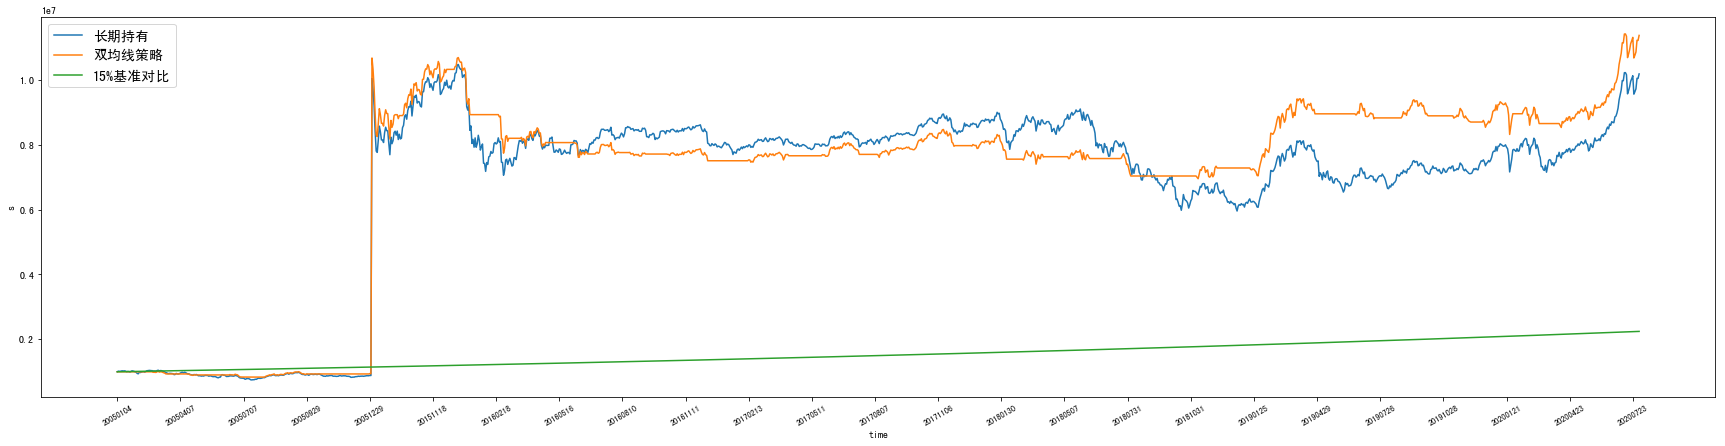

In [313]:
# 本资金模拟交易可能的影响因素：
# 1. 涨停跌停无法交易问题。指数很少有涨跌停，所以影响还可以接受。
# 2. 交易手续费。对指数ETF来说，交易少的情况下，手续费可以忽略。
# 3. 分红。除少数基金有分红，大部分分红可以忽略。
# 4. 交易滑点。才有当天开盘和收盘的平均价格来模拟滑点的影响。

fig=plt.figure(figsize=(30,7))
ax=fig.add_subplot(111)
k = s[0] / close_price[0]
ax.plot(time, close_price * k, label='长期持有')
ax.plot(time,s,label='双均线策略')
ax.plot(time,base_15,label='15%基准对比')
ax.legend(loc='best', prop=fontP)
ax.set_xlabel('time')
ax.set_ylabel('s')
ax.set_xticks(L)
plt.xticks(rotation=30,fontsize='small')
plt.show()

In [115]:
pro.index_weight(index_code='399300.SZ', start_date='20080901', end_date='20100930')

,index_code,con_code,trade_date,weight
0,399300.SZ,600109.SH,20100930,0.10
1,399300.SZ,600688.SH,20100930,0.17
2,399300.SZ,600100.SH,20100930,0.32
3,399300.SZ,601139.SH,20100930,0.06
4,399300.SZ,600009.SH,20100930,0.24
...,...,...,...,...
4995,399300.SZ,600022.SH,20100903,0.10
4996,399300.SZ,000538.SZ,20100903,0.33
4997,399300.SZ,600102.SH,20100903,0.05
4998,399300.SZ,601766.SH,20100903,0.40
